Import Library yang digunakan

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Load data dan Melihat list column data

In [100]:
df = pd.read_csv('bike_sharing_dataset.csv')
df.head()

,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,330.0,629.0,959.0,NaN
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,130.0,651.0,781.0,NaN
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,120.0,1181.0,1301.0,NaN
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,107.0,1429.0,1536.0,NaN
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,82.0,1489.0,1571.0,NaN


visualisasikan data untuk melihat pola nya.

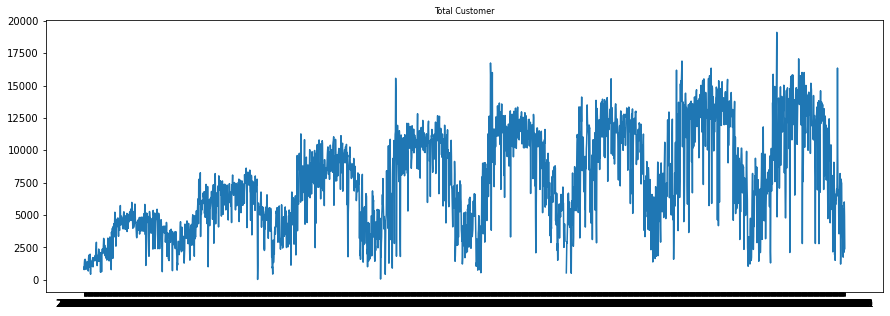

In [40]:
dates = df['date'].values
viz_data  = df['total_cust'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, viz_data)
plt.title('Total Customer',
          fontsize=8);

Visualisasi Temp Observe untuk melihat sekilah pola data

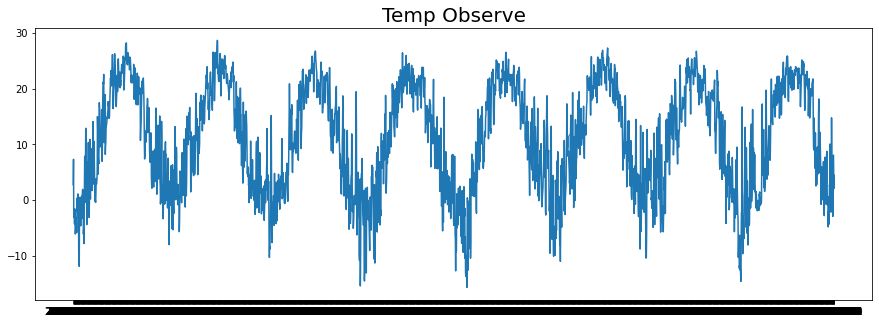

In [41]:
dates = df['date'].values
viz_data  = df['temp_observ'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, viz_data)
plt.title('Temp Observe',
          fontsize=20);

Cleansing Data dengan mengubah Nilai NAN dengan 0 (sesuai dengan fiturnya), lalu melihat sekilas datanya kembali

In [89]:
df = df.fillna(0)
df.head()

,date,temp_observ,precip,total_cust
0,2011-01-01,2.772727,0.069333,959.0
1,2011-01-02,7.327273,1.037349,781.0
2,2011-01-03,-3.060000,1.878824,1301.0
3,2011-01-04,-3.100000,0.000000,1536.0
4,2011-01-05,-1.772727,0.000000,1571.0


drop kolom yang tidak dipakai ( pemilihan kolom paling berpengaruh )

In [103]:
df = df.drop(columns=['wind', 'casual', 'registered', 'temp_avg', 'temp_min', 'temp_max', 'wt_fog', 'wt_heavy_fog', 'wt_thunder', 'wt_sleet', 'wt_hail', 'wt_glaze', 'wt_haze', 'wt_drift_snow', 'wt_high_wind', 'wt_mist', 'wt_drizzle', 'wt_rain', 'wt_freeze_rain', 'wt_snow', 'wt_ground_fog', 'wt_ice_fog', 'wt_freeze_drizzle', 'wt_unknown', 'holiday'])

Normalisasi Data Dengan Min Max Scaler

In [90]:
# Min Max Scaler

df[['temp_observ', 'total_cust']] = preprocessing.MinMaxScaler().fit_transform(df[['temp_observ', 'total_cust']].values)

Menghilangkan outlier pada target data, dan visualisasi ulang data untuk melihat sekilas data

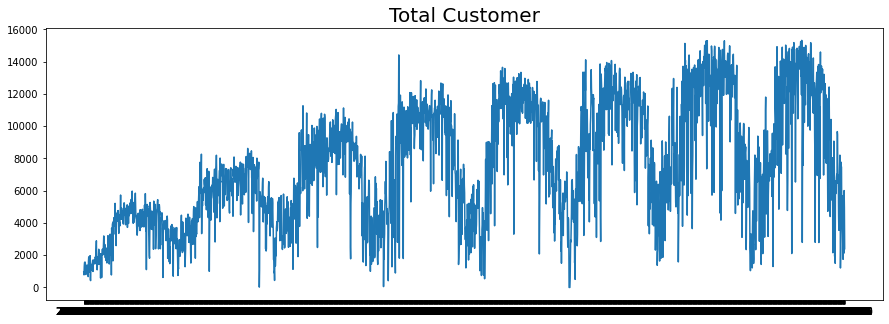

In [44]:
q = df["total_cust"].quantile(0.99)
df = df[df["total_cust"] < q]

dates = df['date'].values
viz_data  = df['total_cust'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, viz_data)
plt.title('Total Customer',
          fontsize=20);

Set Target Data untuk dilakukan prediksi

In [91]:
temp = df['total_cust']

Split Data train dan data test

In [92]:
data_latih, data_test = train_test_split(temp, test_size=0.2, shuffle=False)

Lihat estimasi threshold mae untuk evaluasi model

In [93]:
threshold_mae = (df['total_cust'].max() - df['total_cust'].min()) * 20/100
threshold_mae

0.2

Untuk mengambil kumpulan data dan mempartisinya sesuai dengan parameter yang dimasukan

In [94]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

Membagi dataset dan membuat model untuk sekuensial yang terdiri dari beberapa lapisan. Dan digunakan algoritma LSTM.

In [95]:
train_set = windowed_dataset(data_latih, window_size=20, batch_size=600, shuffle_buffer=1000)
test_set = windowed_dataset(data_test, window_size=20, batch_size=600, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1, activation="relu"),
])

Fungsi Callback untuk menghentikan pembelajaran ketika pembelajaran model sesuai dengan target

In [57]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    threshold_mae = (df['total_cust'].max() - df['total_cust'].min()) * 20/100
    if(logs.get('val_mae')<threshold_mae):
      print("\nMAE < 20%")
      self.model.stop_training = True
callbacks = myCallback()

Eksekusi model

In [96]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-03, momentum=0.98)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30, validation_data=(test_set), callbacks=[callbacks])

Epoch 1/30
4/4 [==============================] - 4s 466ms/step - loss: 0.0842 - mae: 0.3699 - val_loss: 0.1631 - val_mae: 0.5337
Epoch 2/30
4/4 [==============================] - 1s 269ms/step - loss: 0.0840 - mae: 0.3693 - val_loss: 0.1628 - val_mae: 0.5330
Epoch 3/30
4/4 [==============================] - 1s 255ms/step - loss: 0.0835 - mae: 0.3681 - val_loss: 0.1607 - val_mae: 0.5287
Epoch 4/30
4/4 [==============================] - 1s 254ms/step - loss: 0.0823 - mae: 0.3646 - val_loss: 0.1546 - val_mae: 0.5171
Epoch 5/30
4/4 [==============================] - 1s 265ms/step - loss: 0.0801 - mae: 0.3577 - val_loss: 0.1458 - val_mae: 0.5000
Epoch 6/30
4/4 [==============================] - 1s 255ms/step - loss: 0.0757 - mae: 0.3443 - val_loss: 0.1345 - val_mae: 0.4770
Epoch 7/30
4/4 [==============================] - 1s 262ms/step - loss: 0.0685 - mae: 0.3222 - val_loss: 0.1207 - val_mae: 0.4481
Epoch 8/30
4/4 [==============================] - 1s 256ms/step - loss: 0.0588 - mae: 0.29

Visualisasi MAE model

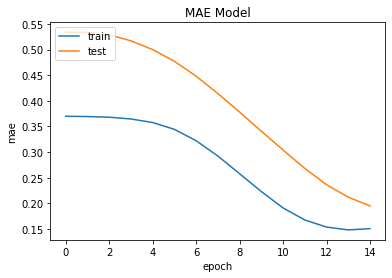

In [97]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Visualisasi Loss Model

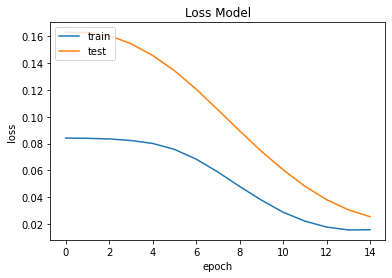

In [98]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()